## mapping tests 

In [1]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd
import random
from snipgenie import trees, app, snp_typing
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

In [2]:
counties = gpd.read_file('https://github.com/dmnfarrell/snipgenie/raw/master/maps/ireland_counties.zip?raw=true')

## make fake data for map/db testing with web app

In [25]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/ireland_metadata.csv',index_col=0)
#meta = meta.drop(columns=['filename','pair'])
#meta = meta.rename(columns={'SB':'spoligotype'})
meta['species'] = meta.species.fillna('Cow')
meta['name'] = meta.index
meta

,county,species,source,batch,aliquot,filename,SB,SequenceName,snp10,snp12,snp15,snp20,snp200,snp3,snp5,snp50,snp8,SB1,name
sample,,,,,,,,,,,,,,,,,,,
ERR125617,NI,Cow,Other,NaN,NaN,/storage/btbgenie/mbovis_ireland/NI/ERR125617_...,SB0140,ERR125617,-1,-1,-1,-1,5,-1,-1,-1,-1,SB0140,ERR125617
ERR125622,NI,Cow,Other,NaN,NaN,/storage/btbgenie/mbovis_ireland/NI/ERR125622_...,SB0140,ERR125622,24,26,28,35,5,15,20,25,22,SB0140,ERR125622
ERR125598,NI,Cow,Other,NaN,NaN,/storage/btbgenie/mbovis_ireland/NI/ERR125598_...,SB0140,ERR125598,-1,-1,35,40,5,-1,-1,24,-1,SB0140,ERR125598
ERR125612,NI,Cow,Other,NaN,NaN,/storage/btbgenie/mbovis_ireland/NI/ERR125612_...,SB0140,ERR125612,68,74,75,71,9,54,67,34,68,SB0140,ERR125612
ERR125603,NI,Cow,Other,NaN,NaN,/storage/btbgenie/mbovis_ireland/NI/ERR125603_...,SB0140,ERR125603,31,35,40,32,4,34,31,10,32,SB0140,ERR125603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TB19-006145,Tipperary,Cow,Kevin,4.0,TB19-006145,/storage/btbgenie/mbovis_ireland/Misc/TB19-006...,SB0140,TB19-006145,6,7,9,9,2,3,6,6,6,SB0140,TB19-006145
TB19-004984,Tipperary,Cow,Kevin,4.0,TB19-004984,/storage/btbgenie/mbovis_ireland/Misc/TB19-004...,SB0146,TB19-004984,-1,-1,-1,-1,4,-1,-1,9,-1,Other,TB19-004984
TB19-005987,Waterford,Cow,Kevin,4.0,TB19-005987,/storage/btbgenie/mbovis_ireland/Misc/TB19-005...,SB0140,TB19-005987,15,16,17,15,2,30,14,6,14,SB0140,TB19-005987


In [26]:
def make_points(x):
    """Make points"""

    if x.county == 'Wicklow':
        bounds=(-6.7,52.8,-6.1,53.2)
    elif x.county == 'Monaghan':
        bounds = (-6.0,54.0,-7.1,54.5)
    else:
        bounds = (-6.4,53.8,-6.1,54.2)
    points = []
    minx, miny, maxx, maxy = bounds   
    point = (random.uniform(minx, maxx), random.uniform(miny, maxy))
    return point

In [27]:
#make random points inside geometry

from shapely.geometry import Point
def random_point_in_shp(x):
   
    if x.county not in counties.NAME_TAG.unique():
        x.county=random.choice(['Armagh','Down'])
    shp = counties[counties.NAME_TAG==x.county].iloc[0] 
    #print (shp)
    within = False
    bounds = shp.geometry.bounds    
    while within is False:
        x = np.random.uniform(bounds[0], bounds[2])
        y = np.random.uniform(bounds[1], bounds[3])        
        within = shp.geometry.contains(Point(x, y))
        #print (within)
    return x,y

#meta.apply(random_point_in_shp,1)

In [28]:
meta['coord'] = meta.apply(random_point_in_shp,1)
meta[['LONG','LAT']] = pd.DataFrame(meta.coord.tolist(), index=meta.index)

In [29]:
sdist = pd.read_csv('/storage/btbgenie/all_ireland_results/snpdist.csv',index_col=0)
#print (sdist)

def find_neighbours(x, n=4):
    """find neighbours from snp distance matrix"""
  
    vals = list(x.sort_values()[1:n].index)
    return ';'.join(vals)

nearest = sdist.apply(find_neighbours,1)
#nearest
meta['nearest'] = nearest

## encode snp data into field

In [30]:
snpm = pd.read_csv('/storage/btbgenie/all_ireland_results/core.txt',sep=' ').set_index('pos').T
snpm = snpm.fillna('N')
meta['snps'] = snpm.apply(snp_typing.encode_snps,1)

In [31]:
print (meta[:4])
meta.to_csv('ireland_test_data.csv')

          county species source  batch aliquot                                           filename      SB SequenceName  snp10  snp12  ...  snp5  snp50  snp8     SB1       name  \
sample                                                                                                                                ...                                         
ERR125617     NI     Cow  Other    NaN     NaN  /storage/btbgenie/mbovis_ireland/NI/ERR125617_...  SB0140    ERR125617     -1     -1  ...    -1     -1    -1  SB0140  ERR125617   
ERR125622     NI     Cow  Other    NaN     NaN  /storage/btbgenie/mbovis_ireland/NI/ERR125622_...  SB0140    ERR125622     24     26  ...    20     25    22  SB0140  ERR125622   
ERR125598     NI     Cow  Other    NaN     NaN  /storage/btbgenie/mbovis_ireland/NI/ERR125598_...  SB0140    ERR125598     -1     -1  ...    -1     24    -1  SB0140  ERR125598   
ERR125612     NI     Cow  Other    NaN     NaN  /storage/btbgenie/mbovis_ireland/NI/ERR125612_...  SB0140

179

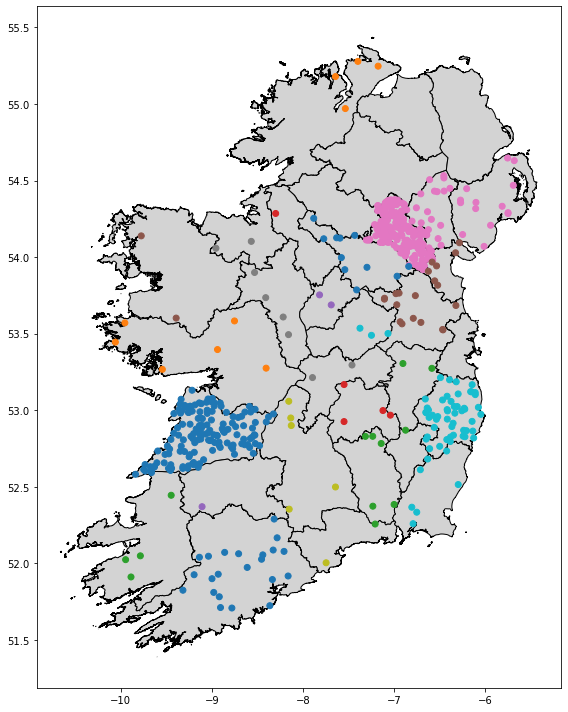

In [38]:
gdf = gpd.GeoDataFrame(meta, geometry=gpd.points_from_xy(meta.LONG, meta.LAT),crs='EPSG:4326')
fig,ax=plt.subplots(1,1,figsize=(10,10))
counties.plot(ax=ax,color='lightgray',ec='black')
gdf.plot(ax=ax,column='county')
plt.tight_layout()
fig.savefig('ireland_samples_map_test.jpg',dpi=150)
len(gdf[gdf.county=='Monaghan'])